# Задание для курсового проекта

Метрика:
rmse -корень среднеквадратичного отклонения

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.


https://www.kaggle.com/competitions/real-estate-price-prediction-moscow/data


**Построение модели регресси**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Подбор моделей, получение бейзлана
7. Проверка качества, борьба с переобучением
8. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [2]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [3]:
train_df.shape[1]-1 == test_df.shape[1]

True

## Приведение типов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

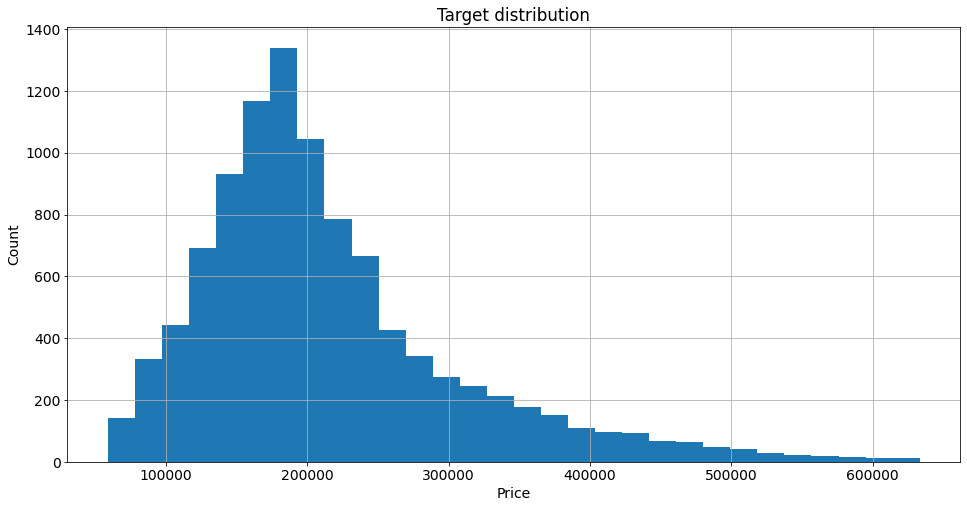

In [4]:
train_df.info()
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

train_df = train_df.drop('Id', axis = 1)

plt.figure(figsize=(16, 8))

train_df['Price'].hist(bins = 30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [5]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [6]:
# качественные переменные
train_df.select_dtypes(include='object').columns.tolist()

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [7]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [8]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## Обработка выбросов 

### Rooms

In [9]:
class Preproc:
    def fit_emiss_rooms(self, data):
        self.emiss_median_rooms = data['Rooms'].median()
        self.emiss_median_LifeSquare = data['LifeSquare'].median()
        

    def transf_emiss_rooms(self, data):
        data.loc[(data['Rooms'] >= 6) | (data['Rooms'] == 0), 'Rooms'] = self.emiss_median_rooms

In [10]:
prep = Preproc()
prep.fit_emiss_rooms(train_df)
prep.transf_emiss_rooms(train_df)
prep.transf_emiss_rooms(test_df)

In [11]:
train_df['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [12]:
median = train_df['Rooms'].median()
train_df.loc[(train_df['Rooms'] >= 6) | (train_df['Rooms'] == 0), 'Rooms'] = median

# train_df.loc[test_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = median

train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.811056,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,5.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Square	LifeSquare	KitchenSquare

In [13]:
train_df.shape

(10000, 19)

In [14]:
# train_df = train_df[
#         (train_df['Square'] < train_df['Square'].quantile(.975)) |
#         (train_df['Square'] > train_df['Square'].quantile(.025))]

# train_df =  train_df[(train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.975)) |
#                      (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.025))]


# train_df =  train_df[(train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.975)) |
#                      (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.025))]

train_df['Square'].fillna(0, inplace=True)
train_df['LifeSquare'].fillna(0, inplace=True)
train_df['KitchenSquare'].fillna(0, inplace=True)

train_df.loc[train_df['Square'] > train_df['Square'].quantile(.975), 'Square'] = train_df['Square'].quantile(.975)
train_df.loc[train_df['Square'] < train_df['Square'].quantile(.025), 'Square'] = train_df['Square'].quantile(.025)
train_df.loc[train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.975), 'LifeSquare'] = train_df['LifeSquare'].quantile(.975)
train_df.loc[train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.025), 'LifeSquare'] = train_df['LifeSquare'].quantile(.025)
train_df.loc[train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975), 'KitchenSquare'] = train_df['KitchenSquare'].quantile(.975)
train_df.loc[train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.025), 'KitchenSquare'] = train_df['KitchenSquare'].quantile(.025)

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [15]:
train_df.shape

(10000, 19)

In [16]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,55.808219,28.059655,6.370500,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.811056,17.214605,20.257241,2.942124,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,32.105183,0.000000,3.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,17.627207,3.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,28.926861,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,5.000000,100.906245,78.385944,13.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Floor	HouseFloor	

In [17]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [18]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [19]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

sum(train_df['Floor'] > train_df['HouseFloor'])

1610

In [20]:
floor_out = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_out, 'Floor'] = train_df.loc[floor_out, 'HouseFloor'].apply(lambda x: random.randint(1, x))

## Обработка пропусков

In [21]:
len(train_df) - train_df.count()

DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [22]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [23]:
len(train_df) - train_df.count()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [24]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,55.808219,28.059655,6.370500,7.383700,12.95910,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,0.811056,17.214605,20.257241,2.942124,5.038215,6.44346,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,1.000000,32.105183,0.000000,3.000000,1.000000,1.00000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,17.627207,3.000000,3.000000,9.00000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,28.926861,6.000000,6.000000,13.00000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,41.427234,9.000000,11.000000,17.00000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,5.000000,100.906245,78.385944,13.000000,42.000000,117.00000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [25]:
train_df['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

## Качественные переменные в OneHot

In [26]:
cols_to_onehot = train_df.select_dtypes(include='object').columns.tolist()
cols_to_onehot

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [27]:
train_df_add_columns = pd.get_dummies(train_df[cols_to_onehot], prefix_sep='__')
train_df = pd.concat([train_df, train_df_add_columns], axis = 1)
train_df = train_df.drop(cols_to_onehot, axis = 1)
train_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,DistrictId__96,DistrictId__97,DistrictId__98,DistrictId__99,Ecology_2__A,Ecology_2__B,Ecology_3__A,Ecology_3__B,Shops_2__A,Shops_2__B
0,3.0,100.906245,0.000000,10.0,4,10.0,2014,0.075424,11,3097,...,0,0,0,0,0,1,0,1,0,1
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,...,0,0,0,0,0,1,0,1,0,1
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,...,0,0,0,0,0,1,0,1,0,1
3,1.0,40.409907,0.000000,3.0,10,22.0,1977,0.007122,1,264,...,0,0,0,0,0,1,0,1,0,1
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,52,10311,...,0,0,0,0,0,1,0,1,0,1
9996,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,2,629,...,0,0,0,0,0,1,0,1,1,0
9997,1.0,32.105183,16.555363,5.0,3,5.0,1958,0.460556,20,4386,...,0,0,0,0,0,1,0,1,0,1
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,...,0,0,0,0,0,1,0,1,0,1


In [28]:
# Оставляем только параметры с хорошей кореляцией с предсказываемой величиной
def get_cor_scores(df, features, target):
    from multiprocessing import cpu_count
    from multiprocessing.dummy import Pool as ThreadPool
    from sklearn.feature_selection import mutual_info_regression

    def make_mi_scores_multithread(X, y, discrete_features='auto'):
        # multithread
        def make_mi_scores(*args):
            # singlethread (uses only one CPU core)
            X, y, discrete_features = list(*args)
            if isinstance(X, pd.Series):
                X = pd.DataFrame(X)
            mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
            mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
            mi_scores = mi_scores.sort_values(ascending=False)
            return mi_scores

        # разделим датасет по колонкам, чтобы сделать несколько потоков обработки
        cpu_cnt = cpu_count()

        # сделаем так, чтобы каждому ядру процессора досталось примерно
        # равное поличество колонок на обработку
        chunk_size = 1
        column_to_process = len(X.columns)
        if cpu_cnt < column_to_process:
            chunk_size = (column_to_process // cpu_cnt) + 1

        X_chunk = [X.iloc[:,i:i + chunk_size] for i in range(0, len(X.columns), chunk_size)]
        args_list = []
        for chunk in X_chunk:
            args_list.append([chunk, y, discrete_features])

        pool = ThreadPool(cpu_cnt)  # параметр - количество потоков
        results = pool.map(make_mi_scores, args_list)  # вернёт список результатов
        pool.close()
        results = pd.concat(results)  # объединяем результаты
        results = pd.DataFrame(results)
        
        assert len(X.columns) == len(results), 'При определении коррелляции параметров с' \
                                       'результатом была утеряна часть данных!'
        return results
    
    df_scores = make_mi_scores_multithread(df[features], df[target])
    df_scores.sort_values(ascending=False, by="MI Scores")
    return df_scores

feat = train_df.drop('Price', axis = 1).columns.to_list()
df_scores = get_cor_scores(train_df, features=feat, target='Price')
df_scores

,MI Scores
Square,0.309867
Social_2,0.263610
Rooms,0.251270
LifeSquare,0.238249
Social_1,0.223366
...,...
DistrictId__75,0.000000
DistrictId__90,0.000000
DistrictId__81,0.000000
DistrictId__60,0.000000


In [29]:
# оставим только те колонки, которые влияют на результат
bad_score_labels = df_scores[(df_scores['MI Scores'] < 0.005) | (df_scores['MI Scores'] >= 0.5)].index.to_list()
train_df = train_df.drop(labels=bad_score_labels, axis=1)
train_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,DistrictId__23,DistrictId__27,DistrictId__34,DistrictId__45,DistrictId__48,DistrictId__53,DistrictId__58,DistrictId__6,Shops_2__A,Shops_2__B
0,3.0,100.906245,0.000000,10.0,4,10.0,2014,0.075424,11,3097,...,0,1,0,0,0,0,0,0,0,1
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,...,0,0,0,0,0,0,0,0,0,1
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,...,0,0,0,0,0,0,0,0,0,1
3,1.0,40.409907,0.000000,3.0,10,22.0,1977,0.007122,1,264,...,0,0,0,0,0,0,0,0,0,1
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,52,10311,...,0,0,0,0,0,0,0,0,0,1
9996,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,2,629,...,0,1,0,0,0,0,0,0,1,0
9997,1.0,32.105183,16.555363,5.0,3,5.0,1958,0.460556,20,4386,...,0,0,0,0,0,0,0,0,0,1
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,...,0,0,0,0,0,0,0,0,0,1


## Разделение на train и test

In [30]:
x = train_df.copy()
y = x.pop('Price')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 21)

In [31]:
forest = RandomForestRegressor()
forest.fit(x_train, y_train)

RandomForestRegressor()

##### отложенная выборка

Train R2:	0.961
Test R2:	0.743


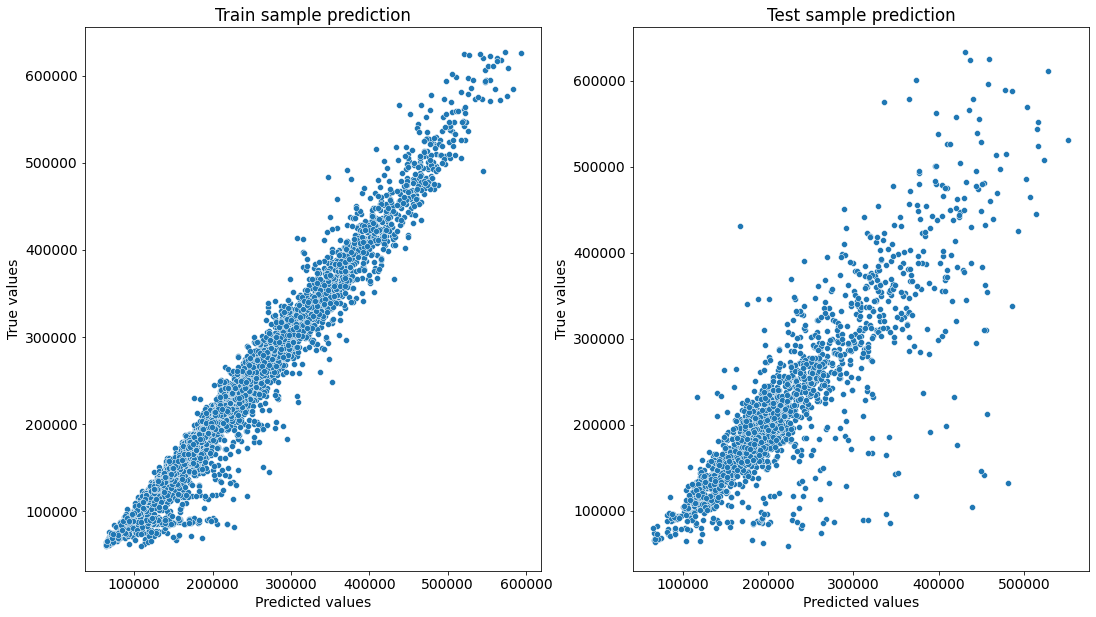

In [32]:
train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)
evaluate_preds(y_train, train_pred, y_test, test_pred)

### тренировка модели

In [33]:
forest = RandomForestRegressor()
forest.fit(x, y)

RandomForestRegressor()

### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [36]:
feat = train_df.drop('Price', axis = 1).columns.to_list()

test_df = pd.read_csv(TEST_DATASET_PATH)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

test_df_ids = test_df['Id']
test_df = test_df.drop('Id', axis = 1)

prep = Preproc()
prep.fit_emiss_rooms(test_df)
prep.transf_emiss_rooms(test_df)
prep.transf_emiss_rooms(test_df)

median = test_df['Rooms'].median()

test_df.loc[(test_df['Rooms'] >= 6) | (test_df['Rooms'] == 0), 'Rooms'] = median

# test_df.loc[test_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = median

import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

test_df['Square'].fillna(0, inplace=True)
test_df['LifeSquare'].fillna(0, inplace=True)
test_df['KitchenSquare'].fillna(0, inplace=True)

test_df.loc[test_df['Square'] > test_df['Square'].quantile(.975), 'Square'] = test_df['Square'].quantile(.975)
test_df.loc[test_df['Square'] < test_df['Square'].quantile(.025), 'Square'] = test_df['Square'].quantile(.025)
test_df.loc[test_df['LifeSquare'] > test_df['LifeSquare'].quantile(.975), 'LifeSquare'] = test_df['LifeSquare'].quantile(.975)
test_df.loc[test_df['LifeSquare'] < test_df['LifeSquare'].quantile(.025), 'LifeSquare'] = test_df['LifeSquare'].quantile(.025)
test_df.loc[test_df['KitchenSquare'] > test_df['KitchenSquare'].quantile(.975), 'KitchenSquare'] = test_df['KitchenSquare'].quantile(.975)
test_df.loc[test_df['KitchenSquare'] < test_df['KitchenSquare'].quantile(.025), 'KitchenSquare'] = test_df['KitchenSquare'].quantile(.025)

test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

floor_out = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

test_df.loc[floor_out, 'Floor'] = test_df.loc[floor_out, 'HouseFloor'].apply(lambda x: random.randint(1, x))

test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

test_df_add_columns = pd.get_dummies(test_df[cols_to_onehot], prefix_sep='__')
test_df = pd.concat([test_df, test_df_add_columns], axis = 1)
test_df = test_df.drop(cols_to_onehot, axis = 1)

test_pred = forest.predict(test_df[feat])
df_test_pred = pd.DataFrame(test_pred.round(), columns=['Price'])
df_test_pred['Id'] = test_df_ids

df_test_pred[['Id', 'Price']].to_csv('data/submission.csv', index=False)

len(df_test_pred)

5000

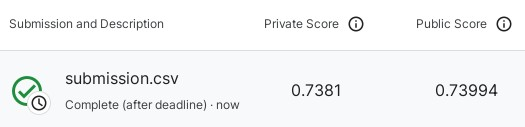